## Wide and Deep模型训练和测试  
1. 生成WD训练数据    
2. 生成WD测试数据  
3. 训练Wide and Deep model  
4. WD模型评估和预测

### 1. 生成WD训练数据  
注意label和columns的顺序，送入input_fn需要舍去head

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
def trainDataForWD(input_file,output_file):
    dpath = "./data/"
    fin = open(dpath+input_file,"r")
    fout = open(dpath+output_file,"w")
    start = 0
    for line in fin:
        if start==0:
            start+=1
            continue
        cols = line.strip().split(",")
        outcols = [cols[-1]]+cols[-6:-1]+[cols[-10]]+cols[-9:-6]+cols[2:-10]
        fout.write(",".join(outcols)+"\n")
    fin.close()
    fout.close()       

In [3]:
%%time
trainDataForWD("train_final.csv","train_wd.csv")

Wall time: 28.5 s


In [21]:
train_wd = pd.read_csv("./data/train_wd.csv",header=None)

In [5]:
train_wd.iloc[0:5,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1,15.581,0.795,0.506,0.474,0.53734,-0.25183,17,8,0,1,6,5,1,0,2,7,8,13
1,1,1.991,-0.081,0.743,1.000,0.99810,0.23361,6,8,0,3,7,3,13,4,0,9,7,13
2,1,1.991,-0.072,0.743,0.500,-0.04898,-0.13422,6,8,0,3,7,3,13,4,0,9,7,13
3,1,1.991,-0.081,0.743,1.000,0.99810,0.05294,40,0,0,3,7,3,13,4,0,9,7,13
4,1,15.581,1.211,0.506,0.364,0.38750,-0.36784,1,8,0,1,6,5,1,0,2,7,8,13


In [6]:
train_wd.shape

(7377403, 19)

### 2. 生成WD测试数据

In [7]:
def testDataForWD(input_file,output_file):
    dpath = "./data/"
    fin = open(dpath+input_file,"r")
    fout = open(dpath+output_file,"w")
    start = 0
    for line in fin:
        if start==0:
            start+=1
            continue
        cols = line.strip().split(",")
        outcols = cols[-5:]+[cols[-9]]+cols[-8:-5]+cols[3:-9]
        fout.write(",".join(outcols)+"\n")
    fin.close()
    fout.close()       

In [8]:
%%time
testDataForWD("test_final.csv","test_wd.csv")

Wall time: 9.62 s


In [17]:
test_wd = pd.read_csv("./data/test_wd.csv",header=None)

In [18]:
test_wd.iloc[0:5,:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.401,2.944,0.366,0.504,0.38083,-0.14208,24,4,0,3,7,2,1,0,2,7,12,13
1,-0.401,32.878,0.366,0.625,0.53185,0.45662,25,4,0,3,7,2,1,0,2,7,12,13
2,-0.594,-0.072,0.144,0.400,-0.88885,0.42822,12,2,0,0,16,9,1,0,2,4,12,12
3,-0.034,-0.029,0.296,0.226,-0.18739,0.23750,25,8,0,7,11,7,3,5,1,9,3,13
4,-0.034,-0.072,0.296,0.400,0.98938,-0.30702,32,0,0,7,11,7,3,5,1,9,3,13


In [11]:
test_wd.shape

(2556790, 18)

### 3. 训练Wide and Deep model

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO) # Set to INFO for tracking training, default is WARN. ERROR for least messages

print("Using TensorFlow version %s\n" % (tf.__version__))

Using TensorFlow version 1.13.1



1.构建feature columns 

In [3]:
CONTINUOUS_COLUMNS =  ["user_pop","item_pop","user_rate","item_rate","lfm_reco","song_length"] 
CATEGORICAL_COLUMNS = ["genre_ids","language","mult_genre","source_system_tab","source_screen_name","source_type",\
                       "city","bd","gender","registered_via","registration_init_time","expiration_date"] 
LABEL_COLUMN = ["target"]

TRAIN_DATA_COLUMNS = LABEL_COLUMN+ CONTINUOUS_COLUMNS + CATEGORICAL_COLUMNS
TEST_DATA_COLUMNS = CONTINUOUS_COLUMNS + CATEGORICAL_COLUMNS

FEATURE_COLUMNS = CONTINUOUS_COLUMNS + CATEGORICAL_COLUMNS

print('Feature columns are: ', FEATURE_COLUMNS, '\n')

Feature columns are:  ['user_pop', 'item_pop', 'user_rate', 'item_rate', 'lfm_reco', 'song_length', 'genre_ids', 'language', 'mult_genre', 'source_system_tab', 'source_screen_name', 'source_type', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'expiration_date'] 



2.读取数据

In [4]:
def generate_input_fn(filepath, batch_size):
    def _input_fn():
        filepath_queue = tf.train.string_input_producer([filepath])
        reader = tf.TextLineReader()
        key, value = reader.read_up_to(filepath_queue, num_records=batch_size)

        cont_defaults = [ [0.] for i in range(6) ]
        cate_defaults = [ [" "] for i in range(12) ]
        label_defaults = [ [0] ]
        
        if filepath=="./data/train_wd.csv":
            column_headers = TRAIN_DATA_COLUMNS
            record_defaults = label_defaults + cont_defaults + cate_defaults
            columns = tf.decode_csv(
                value, record_defaults=record_defaults)
            all_columns = dict(zip(column_headers, columns))
            labels = all_columns.pop(LABEL_COLUMN[0])
            features = all_columns 
            for feature_name in CATEGORICAL_COLUMNS:
                features[feature_name] = tf.expand_dims(features[feature_name], -1)
            return features, labels
        
        if filepath=="./data/test_wd.csv":
            column_headers = TEST_DATA_COLUMNS
            record_defaults = cont_defaults + cate_defaults
            columns = tf.decode_csv(
                value, record_defaults=record_defaults)
            all_columns = dict(zip(column_headers, columns))
            features = all_columns 
            for feature_name in CATEGORICAL_COLUMNS:
                features[feature_name] = tf.expand_dims(features[feature_name], -1)
            return features
            
    return _input_fn

print('input function configured')

input function configured


3.构建特征

In [5]:
wide_columns = []
for name in CATEGORICAL_COLUMNS:
    wide_columns.append(tf.feature_column.categorical_column_with_hash_bucket(
            name, hash_bucket_size=512))

print('Wide/Sparse columns configured')

Wide/Sparse columns configured


In [6]:
deep_columns = []
for name in CONTINUOUS_COLUMNS:
    deep_columns.append(tf.feature_column.numeric_column(name))

print('deep/continuous columns configured')

deep/continuous columns configured


In [7]:
# Embeddings for wide columns into deep columns
for col in wide_columns:
    deep_columns.append(tf.feature_column.embedding_column\
                        (col, dimension=9))

print('wide and deep columns configured')

wide and deep columns configured


4.初始化WD模型

In [8]:
def create_model_dir(model_type):
    return 'WD_models/model_' + model_type + '_' + str(int(time.time()))

def get_model(model_type, model_dir):
    print("Model directory = %s" % model_dir)

    runconfig = tf.estimator.RunConfig(
        save_checkpoints_secs=None,
        save_checkpoints_steps = 100,)
    
    model = None
    
    # Linear Classifier
    if model_type == 'WIDE':
        model = tf.estimator.LinearClassifier(
            model_dir=model_dir, 
            feature_columns=wide_columns,
            optimizer=tf.train.FtrlOptimizer(0.1, l2_regularization_strength=1.0))

    # Deep Neural Net Classifier
    if model_type == 'DEEP':
        model = tf.estimator.DNNClassifier(
            model_dir=model_dir,
            feature_columns=deep_columns,
            hidden_units=[64,16],
            optimizer= tf.train.ProximalAdagradOptimizer(learning_rate=0.1, \
                            l1_regularization_strength=0.001,l2_regularization_strength=0.001),)

    # Combined Linear and Deep Classifier
    if model_type == 'WIDE_AND_DEEP':
        model = tf.estimator.DNNLinearCombinedClassifier(
            model_dir=model_dir,
            linear_feature_columns=wide_columns,
            linear_optimizer=tf.train.FtrlOptimizer(0.1, l2_regularization_strength=1.0),
            dnn_feature_columns=deep_columns,
            dnn_optimizer= tf.train.ProximalAdagradOptimizer(learning_rate=0.1, \
                            l1_regularization_strength=0.001,l2_regularization_strength=0.001),
            dnn_hidden_units=[128,64,32,16],
            config=runconfig)
        
    print('estimator built')
    return model

5.训练WD模型

In [9]:
train_file = "./data/train_wd.csv"
test_file  = "./data/test_wd.csv"
train_sample_size = 7377403
BATCH_SIZE = 2000
train_steps = train_sample_size/BATCH_SIZE # 7377403/2000 

In [10]:
%%time
MODEL_TYPE = 'WIDE_AND_DEEP'
model_dir = create_model_dir(model_type=MODEL_TYPE)
wd_model = get_model(model_type=MODEL_TYPE, model_dir=model_dir)
wd_model.train(input_fn=generate_input_fn(train_file, BATCH_SIZE), steps=train_steps)
print('wide and deep model fit done')

Model directory = WD_models/model_WIDE_AND_DEEP_1570200215
INFO:tensorflow:Using config: {'_model_dir': 'WD_models/model_WIDE_AND_DEEP_1570200215', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D9A0CACEF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
estimator built
Instructions for updating:
Colocations handled automatically by placer.
Inst

INFO:tensorflow:global_step/sec: 14.6861
INFO:tensorflow:loss = 1157.788, step = 1501 (6.797 sec)
INFO:tensorflow:Saving checkpoints for 1600 into WD_models/model_WIDE_AND_DEEP_1570200215\model.ckpt.
INFO:tensorflow:global_step/sec: 18.4455
INFO:tensorflow:loss = 1096.1296, step = 1601 (5.430 sec)
INFO:tensorflow:Saving checkpoints for 1700 into WD_models/model_WIDE_AND_DEEP_1570200215\model.ckpt.
INFO:tensorflow:global_step/sec: 18.1577
INFO:tensorflow:loss = 1160.27, step = 1701 (5.512 sec)
INFO:tensorflow:Saving checkpoints for 1800 into WD_models/model_WIDE_AND_DEEP_1570200215\model.ckpt.
INFO:tensorflow:global_step/sec: 20.989
INFO:tensorflow:loss = 1142.5098, step = 1801 (4.757 sec)
INFO:tensorflow:Saving checkpoints for 1900 into WD_models/model_WIDE_AND_DEEP_1570200215\model.ckpt.
INFO:tensorflow:global_step/sec: 21.7049
INFO:tensorflow:loss = 1180.796, step = 1901 (4.602 sec)
INFO:tensorflow:Saving checkpoints for 2000 into WD_models/model_WIDE_AND_DEEP_1570200215\model.ckpt.


### 4. WD模型评估和预测

In [11]:
#predict返回一个生成器
train_results = wd_model.predict(input_fn=generate_input_fn(train_file, BATCH_SIZE))

In [12]:
test_results = wd_model.predict(input_fn=generate_input_fn(test_file, BATCH_SIZE))

1.评估

In [13]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [14]:
train_proba = []
for i in range(7377403):
    one_res = next(train_results)["probabilities"]
    train_proba.append(one_res)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from WD_models/model_WIDE_AND_DEEP_1570200215\model.ckpt-3689
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [15]:
train_proba = np.array(train_proba)
train_proba.shape

(7377403, 2)

In [22]:
train_target = train_wd.iloc[:,0].values
train_target.shape

(7377403,)

In [23]:
roc_auc_score(train_target,train_proba[:,1])

0.7755699600506679

In [107]:
fpr,tpr,thresholds = metrics.roc_curve(train_target,train_proba[:,1])

In [108]:
metrics.auc(fpr, tpr)

0.7763867628090612

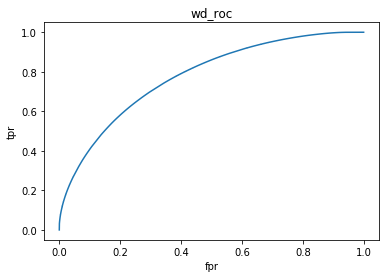

In [110]:
from matplotlib import pyplot as plt 
plt.title("wd_roc") 
plt.xlabel("fpr") 
plt.ylabel("tpr") 
plt.plot(fpr,tpr) 
plt.show()

In [24]:
#保存结果
pickle.dump(train_proba,open("./model/wd_pred.pkl","wb"))

2.预测

In [90]:
test_proba = []
for i in range(2556790):
    one_res = next(test_results)["probabilities"]
    test_proba.append(one_res)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from WD_models/model_WIDE_AND_DEEP_1567750302\model.ckpt-3689
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [91]:
test_proba = np.array(test_proba)

In [92]:
test_proba.shape

(2556790, 2)

3.提交结果

In [96]:
def submit(submission_file):
    f = open(submission_file,"w+")
    ocolnames = ["id","target"]
    f.write(",".join(ocolnames)+"\n")
    outcols = []
    for i in range(len(test_proba)):
        col1 = i
        col2 = test_proba[:,1][i]
        outcols = [str(col1),str(col2)]
        f.write(",".join(outcols)+"\n")
    f.close()

In [97]:
submit("./submission/submission_wd.csv")

In [101]:
submission_wd= pd.read_csv("./submission/submission_wd.csv")

In [102]:
submission_wd.shape

(2556790, 2)

In [105]:
submission_wd.head(20)

,id,target
0,0,0.309036
1,1,0.313812
2,2,0.094208
3,3,0.068431
4,4,0.181079
5,5,0.110071
6,6,0.111275
7,7,0.259496
8,8,0.150790
9,9,0.628534
